In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit, prange

import CP_ALS3 as cp

In [2]:
@jit(nopython=True)
def generate_system(coo_tensor, val, shape, mode, a, b, l2, step):
    mtx = np.zeros((a.shape[1], a.shape[1]))
    right = np.zeros((a.shape[1]))
    coo_step = coo_tensor[coo_tensor[:, mode] == step]
    
    if mode == 0:
        mode_a = 1 
        mode_b = 2
        
    elif mode == 1:
        mode_a = 0
        mode_b = 2
        
    else:
        mode_a = 0
        mode_b = 1
        
    for i in range(a.shape[1]):
        for j in range(a.shape[1]):
            for item in range(coo_step.shape[0]):
                coord = coo_step[item]
                mtx[i, j] += (a[coord[mode_a], i] 
                              * b[coord[mode_b], i] 
                              * a[coord[mode_a], j] 
                              * b[coord[mode_b], j])
                if i == 0:
                    right[j] += a[coord[mode_a], j] * b[coord[mode_b], j] * vals[item]
            
            if i == j:
                mtx[i, j] += l2
    
    return mtx, right

In [3]:
@jit(nopython=True) 
def wrcp_als3(coo_tensor,
              vals,
              shape,
              rank=5,
              l2=0.5,
              max_iter=50,
              tol=1e-8):
    
    a = np.random.rand(shape[0], rank)
    b = np.random.rand(shape[1], rank)
    c = np.random.rand(shape[2], rank)
    err_arr = np.empty((max_iter, 1))  
    
    it = 0
    err1 = 1.0
    err2 = 0.0
    while np.abs(err1 - err2) > tol:
        it += 1
        
        for i in range(shape[0]):
            A, right = generate_system(coo_tensor,
                                       vals,
                                       shape,
                                       0,
                                       b,
                                       c, 
                                       l2,
                                       i)
            
            a[i, :] = np.linalg.solve(A, right)
            
        for j in range(shape[1]):
            A, right = generate_system(coo_tensor,
                                       vals,
                                       shape,
                                       1,
                                       a,
                                       c, 
                                       l2,
                                       j)
            
            b[j :] = np.linalg.solve(A, right)
            
        for k in range(shape[2]):   
            A, right = generate_system(coo_tensor,
                                       vals,
                                       shape,
                                       2,
                                       a,
                                       b, 
                                       l2,
                                       k)
            
            c[k, :] = np.linalg.solve(A, right)
    
        error = cp.sqrt_err_relative(coo_tensor, vals, shape, a, b, c)
        err_arr[it - 1] = error
        err2 = err1
        err1 = error
        if it == max_iter:
            print("iterations over")
            break
    
    return a, b, c, err_arr

In [44]:
%%time
init_shape = (10, 20, 30)
coo, vals = cp.gen_coo_tensor(init_shape, density=0.02)
assert cp.check_coo_tensor(coo)!= "Bad"

CPU times: user 1.91 ms, sys: 0 ns, total: 1.91 ms
Wall time: 1.92 ms


In [45]:
coo.shape[0]

120

In [120]:
%%time
max_iter = 12
rank = 40
a, b, c, err = wrcp_als3(coo, vals, init_shape, rank=rank, l2=0.25, max_iter=max_iter)

iterations over
CPU times: user 88.8 ms, sys: 13 µs, total: 88.8 ms
Wall time: 88.2 ms


In [121]:
error = cp.sqrt_err(coo, vals, init_shape, a, b, c)
rerror = cp.sqrt_err_relative(coo, vals, init_shape, a, b, c)
print(f"Abs err = {error};\nRel err = {rerror};")

Abs err = 33.95256229896487;
Rel err = 5.283128444507683;


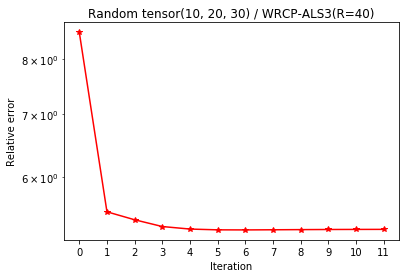

In [122]:
plt.xlabel("Iteration")
plt.ylabel("Relative error")
plt.title(f"Random tensor{init_shape} / WRCP-ALS3(R={rank})")
plt.xticks(np.arange(max_iter))
plt.yscale("log")
plt.plot(np.arange(max_iter), err[:max_iter], 'r-*')